In [22]:
from glob import glob
import os
from itertools import combinations

from tqdm import tqdm
import pandas as pd

In [28]:
sigles = [os.path.basename(fn).replace('xml_', '').replace('.xml', '') for fn in glob('../data/xml_martijn/*.xml')]
sigles = sorted(sigles)
sigles

['A',
 'Ant',
 'B',
 'BR',
 'C',
 'D',
 'D2',
 'E',
 'F',
 'Ge',
 'K',
 'L',
 'O',
 'W',
 'Y',
 'Z']

In [36]:
sigles = 'F', 'L'

In [62]:
from lxml import etree
from re import sub #re — Regular expression operations #
import xml.etree.ElementTree as ET


NSMAP = {'MVN': 'http://www.tei-c.org/ns/1.0'}
removes = ('teiHeader', 'fw', 'supplied', 'abbr') 
removes_expan_false = ('teiHeader', 'fw', 'supplied', 'ex', 'expan')

def extract_lines(xml_file, expan = True): #added a 'flag' to the extraction function --> if... else
    lines = {}
    tree = etree.parse(xml_file)
    if expan:
        #delete all elements with the provided tag names from a tree or subtree
        #will also remove the tail text unless explicitly set the with_tail keyword argument option to False
        etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes), with_tail=False) 
    else: 
        etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes_expan_false), with_tail=False) 
            
            
    chars = {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 
             'k', 'l','m', 'n', 'o', 'p', 'q', 'r', 's', 't', 
             'u', 'v', 'w', 'x', 'y', 'z'}
            
    context = etree.iterwalk(tree, events=("start", "end")) #a tree walker generates events from an existing tree. 'Start' and 'end' represent opening and closing elements
    #u prefix indicates Unicode
    text = u"" 
    #this will be the key in the dictionary of lines {}
    k = '' 
    for action, node in context:
        #remove ns for easier access
        #tag_only bevat de tags op een knooppunt
        #.tag selects all child elements with the given tag. A tag is a string identifying what kind of data this element represents (the element type, in other words).
        #.replace removes ns www.tei...
        
        tag_only = node.tag.replace("{http://www.tei-c.org/ns/1.0}","") 

        #node.attrib: XML elements have attributes 
        #attrib is a dictionary containing the element’s attributes. 
        if 'n' in node.attrib and tag_only == 'text': 
            title = node.attrib['n'] #for example Eerste Martijn
        
        if 'n' in node.attrib and tag_only == "l":
            k = title + '-' + node.attrib['n'] #for example 001, 002, 003...
  
        # if a new pb (standalone element) is processed:
        if action == 'start' and tag_only == 'text': 
            continue
            
        # if new lb (standalone) is processed:
        elif action == 'start' and tag_only == 'lb':
            continue

        # list elements which you want to iterate through. this is not really neccessary.
        elif tag_only in ("group","text","MVN","body","cb","p"):
            continue

        # for all other elements, distinguish between the start-event of the processing and
        # and the end-event. Attach the tail AFTER the child nodes were processed (= end-event) 

        elif action == 'start':
            #comment the following two lines out to not get the element markers
            #f.write(f"[{tag_only}]") 
            #text += f"[{tag_only}]"

            ############################################################################
            ########## filter out special characters, bars,                   ##########
            ########## superscript, or specific tags.                         ##########
            ############################################################################
            
            #if a special glyph is present, encode it accordingly
            if tag_only == 'g':

                if node.attrib['ref'] == '#bar': # ā, ē, ī, ō, ū, n̄ etc.
                    text += u'\u0304'

                elif node.attrib['ref'] == '#apomod': # ʼ
                    text += u'\u02bc'

                elif node.attrib['ref'] == '#usmod': # ꝰ
                    text += u'\ua770'

                elif node.attrib['ref'] == '#condes': # ꝯ
                    text += u'\ua76f'

                elif node.attrib['ref'] == '#para': # ¶
                    text += u'\xb6'

                elif node.attrib['ref'] == '#etfin': # ꝫ
                    text += u'\ua76b'

                elif node.attrib['ref'] == '#pbardes': # ꝑ
                    text += u'\ua751'

                elif node.attrib['ref'] == '#pbardes': # ꝕ
                    text += u'\ua755'

                elif node.attrib['ref'] == '#pflour': # ꝓ
                    text += u'\ua753'

                else:
                    node.attrib['ref']
                    text += str(node.attrib['ref']) # get the actual ref if there still are any left

            #encode superscript letters
            superscript_dict = {'a':'ᵃ', 'b':'ᵇ', 'c':'ᶜ', 'd':'ᵈ', 'e':'ᵉ', 'f':'ᶠ',
                               'g':'ᵍ', 'h':'ʰ', 'i':'ᶦ', 'j':'ʲ', 'k':'ᵏ', 'l':'ˡ', 
                                'm':'ᵐ', 'n':'ⁿ', 'o':'ᵒ', 'p':'ᵖ', 'r':'ʳ', 's':'ˢ', 
                                't':'ᵗ', 'u':'ᵘ', 'v':'ᵛ', 'w':'ʷ', 'x':'ˣ', 'y': 'ʸ', 'z': 'ᶻ'}

            if tag_only == 'hi' and 'rend' in node.attrib and node.attrib['rend'] == 'superscript': #rend(ition) supplies information about the appearance of an element
                if node.text in superscript_dict:
                    text += str(superscript_dict[node.text]).strip()

            #encode punctuation marks
            elif tag_only == 'pc':
                text += str(node.text).strip()

            #encode roman numerals
            elif tag_only == 'num':
                if node.text:
                    text += str('.'+node.text+'.').strip()

            #if there is still a node with text in it
            elif (node.text):
                text += node.text        

        #after the child elements
        elif action == 'end':
            #if there is a tail
            #the tail attribute holds the text between the element’s end tag and the next tag, or None
            if (node.tail and node.tail not in "\t"): #if the tail is not yet in the text 
                #comment the following two lines out to not get the tail marker
                #text += "[tail]"
                #f.write("[tail]")
                #append to text-concatenation
                text += str(node.tail)
        if tag_only == 'lb':
            if k:
                text = sub(r'\n', '', text) #when an "r" prefix is present, a character following a backslash is included in the string/all backslashes are left in string. 
                lines[k] = text #the value of the keys k is the text 
                text = '' 
    print(lines) 
    return lines

d = extract_lines(f'../data/xml_martijn/xml_{sigles[0]}.xml', expan = False)

{'Eerste Martijn-001': 'WApene merten hoe', 'Eerste Martijn-002': 'saelt gaen. 2 Sal dese', 'Eerste Martijn-003': 'In dus cranckē geloue.', 'Eerste Martijn-004': 'Soe sal mijn vrouwe vā eerē saen', 'Eerste Martijn-005': 'Sonder twiuel ende waen', 'Eerste Martijn-006': 'Rumen der heeren houe.', 'Eerste Martijn-007': 'Ic zie den scalkē wel ontfaen', 'Eerste Martijn-008': 'Die de heeren connē dwaen', 'Eerste Martijn-010': 'Ende plucken vanden stoue', 'Eerste Martijn-011': 'Ic zye den gherechten slaen', 'Eerste Martijn-012': 'Beyde bescatten en̄ vaen', 'Eerste Martijn-013': 'Alse die meese in die cloue', 'Eerste Martijn-014': 'Recht often god verscroue.', 'Eerste Martijn-015': 'God. die alle dinc besit', 'Eerste Martijn-016': 'In ziine heerscappie', 'Eerste Martijn-017': 'Dattie goede vleeut en̄ bid', 'Eerste Martijn-018': 'Hem en doech dat no dit', 'Eerste Martijn-019': 'Datti ye ghedye.', 'Eerste Martijn-020': 'Al gaet inden helschen pit/', 'Eerste Martijn-021': 'Eest grau blau zwer

In [5]:
d = extract_lines(f'../data/xml_martijn/xml_{sigles[0]}.xml', expan = False)
print(d)

{'Eerste Martijn-001': 'WApene merten hoe', 'Eerste Martijn-002': 'saelt gaen. 2 Sal dese', 'Eerste Martijn-003': 'In dus cranckē geloue.', 'Eerste Martijn-004': 'Soe sal mijn vrouwe vā eerē saen', 'Eerste Martijn-005': 'Sonder twiuel ende waen', 'Eerste Martijn-006': 'Rumen der heeren houe.', 'Eerste Martijn-007': 'Ic zie den scalkē wel ontfaen', 'Eerste Martijn-008': 'Die de heeren connē dwaen', 'Eerste Martijn-010': 'Ende plucken vanden stoue', 'Eerste Martijn-011': 'Ic zye den gherechten slaen', 'Eerste Martijn-012': 'Beyde bescatten en̄ vaen', 'Eerste Martijn-013': 'Alse die meese in die cloue', 'Eerste Martijn-014': 'Recht often god verscroue.', 'Eerste Martijn-015': 'God. die alle dinc besit', 'Eerste Martijn-016': 'In ziine heerscappie', 'Eerste Martijn-017': 'Dattie goede vleeut en̄ bid', 'Eerste Martijn-018': 'Hem en doech dat no dit', 'Eerste Martijn-019': 'Datti ye ghedye.', 'Eerste Martijn-020': 'Al gaet inden helschen pit/', 'Eerste Martijn-021': 'Eest grau blau zwer

In [6]:
mss = {}

for sigle in tqdm(sigles):
    mss[sigle] = extract_lines(f'../data/xml_martijn/xml_{sigle}.xml', expan = False)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.81it/s]

{'Eerste Martijn-001': 'WApene merten hoe', 'Eerste Martijn-002': 'saelt gaen. 2 Sal dese', 'Eerste Martijn-003': 'In dus cranckē geloue.', 'Eerste Martijn-004': 'Soe sal mijn vrouwe vā eerē saen', 'Eerste Martijn-005': 'Sonder twiuel ende waen', 'Eerste Martijn-006': 'Rumen der heeren houe.', 'Eerste Martijn-007': 'Ic zie den scalkē wel ontfaen', 'Eerste Martijn-008': 'Die de heeren connē dwaen', 'Eerste Martijn-010': 'Ende plucken vanden stoue', 'Eerste Martijn-011': 'Ic zye den gherechten slaen', 'Eerste Martijn-012': 'Beyde bescatten en̄ vaen', 'Eerste Martijn-013': 'Alse die meese in die cloue', 'Eerste Martijn-014': 'Recht often god verscroue.', 'Eerste Martijn-015': 'God. die alle dinc besit', 'Eerste Martijn-016': 'In ziine heerscappie', 'Eerste Martijn-017': 'Dattie goede vleeut en̄ bid', 'Eerste Martijn-018': 'Hem en doech dat no dit', 'Eerste Martijn-019': 'Datti ye ghedye.', 'Eerste Martijn-020': 'Al gaet inden helschen pit/', 'Eerste Martijn-021': 'Eest grau blau zwer

In [126]:
print(mss.keys())

dict_keys(['F', 'L'])


In [127]:
import numpy as np

# from: https://gist.github.com/slowkow/06c6dba9180d013dfd82bec217d22eb5

def nw(x, y, match = 1, mismatch = 1, gap = 1):
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx, nx + 1)
    F[0,:] = np.linspace(0, -ny, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    return rx, ry

In [128]:
distances = []

for ms1, ms2 in tqdm(list(combinations(mss.keys(), 2))):
    common_idxs = set(mss[ms1].keys()).intersection(set(mss[ms2].keys()))
    for idx in common_idxs:
        line1, line2 = mss[ms1][idx], mss[ms2][idx]
        print('=================')
        rx, ry = nw(line1, line2)
        assert len(rx) == len(ry) 
        print('\n'.join([rx, ry]))
        length = len(rx)
        for idx, (a, b) in enumerate(zip(rx, ry)):
            if a != b:
                distances.append((ms1, ms2, idx/length, 1))
            else:
                distances.append((ms1, ms2, idx/length, 0))

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Daer niemant vut en comt
D--ʼ niement -wt en comt
En es coninc no-- conīghinne
En es coninc noch conīghinne
Inden lesten ma-le
------lesten maele
Dat godlike cleyt
Dat godlike cleit
Buten sijnre hoeden
Buten si-ere hoeden
Onse dyalo-ghe.
Onse dyaloeghe-
Hier in waert tsekerst te volstaen
Hier in waert -sekers--t- -----...
Sij slechten den wiin- enter gloet
Si- slechten den w-ine ent-ʼ gloet
Die ware god- die alre meeste
Die ware gode die aldʼ neeste
Minne int verto-ghen
Minne int v-ʼtoeghen
En-̄ niet en scelden den heere.
Ende niet--- scelden den h-----
Daermē af tellet alle woort
D-----ʼ af tellen alle woort
Met ghesta-der trouwen
Met g-estaeder trouwen
Zeght mi wanē dit fenijn ran
Seg-t mi wanen --t-fe-------n
Dat nēmermeer te nieute gheit
D-ꝫ nēmermeer--- -----vʼgheit
A-rbeyt vint vier in-den steen
Aerbeit vint vier in den steen
DIe gods sone to-echt ons dat
--- gods sone toge--t ons dat
Daer wij omme -selen beuen
D--ʼ wi- om̄e moeten beuen
Wie was diese--r toe haelde
Wie -es 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Dat behoet hij ende besat
Dat behoet hi- ende besat
Ende zeere onghetr-eden
---e zeere ong-etreeden
Dat hij van sinen volleeste
D-ꝫ hi- vā sinen vo-l--...
Mer hets der herten plien
M-ʼ hets der herten plien
Al dat weluarens begheert
Al dat weluarens beg-aert
Daert dore qua-m ghevlo-ghen
D---ʼ dore quaem gheuloeg-en
En̄ edelheyt daer o-m- green
-------lheit d--ʼ ōme green


In [129]:
mismatches = pd.DataFrame(distances, columns=('ms1', 'ms2', 'position', 'mismatch'))
mismatches.head(40)
mismatches

,ms1,ms2,position,mismatch
0,F,L,0.000000,0
1,F,L,0.041667,1
2,F,L,0.083333,1
3,F,L,0.125000,1
4,F,L,0.166667,0
...,...,...,...,...
15531,F,L,0.821429,0
15532,F,L,0.857143,0
15533,F,L,0.892857,0
15534,F,L,0.928571,0


(474,)

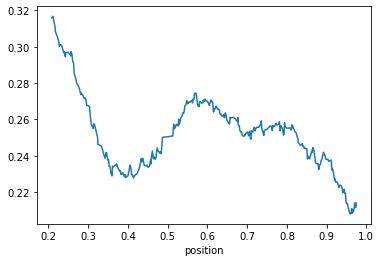

In [130]:
rolling_window = mismatches.groupby('position')['mismatch'].mean().rolling(window=100).mean()

rolling_window.plot();
rolling_window.shape

## Now create bins for positions in verse line

In [32]:
bins = 25 # how many bins?

edges = np.linspace(mismatches.position.min(), mismatches.position.max(), bins+1).astype(float).round(2)

labels = [f'({edges[i]}, {edges[i+1]}]' for i in range(bins)]
mismatches['position_binned'] = pd.cut(mismatches.position, bins=bins, labels=labels)
mismatches['combo'] = mismatches["ms1"]+'-'+mismatches["ms2"]

mismatches

,ms1,ms2,position,mismatch,position_binned,combo
0,K,L,0.000000,1,"(0.0, 0.04]",K-L
1,K,L,0.047619,1,"(0.04, 0.08]",K-L
2,K,L,0.095238,1,"(0.08, 0.12]",K-L
3,K,L,0.142857,1,"(0.12, 0.16]",K-L
4,K,L,0.190476,1,"(0.16, 0.19]",K-L
...,...,...,...,...,...,...
1378,K,L,0.800000,0,"(0.78, 0.82]",K-L
1379,K,L,0.840000,0,"(0.82, 0.85]",K-L
1380,K,L,0.880000,1,"(0.85, 0.89]",K-L
1381,K,L,0.920000,1,"(0.89, 0.93]",K-L


In [50]:
df_binned = mismatches.groupby(['position_binned', 'combo'])['mismatch'].sum().reset_index()
df_binned

,position_binned,combo,mismatch
0,"(0.0, 0.04]",A-C,444
1,"(0.04, 0.08]",A-C,263
2,"(0.08, 0.12]",A-C,308
3,"(0.12, 0.16]",A-C,315
4,"(0.16, 0.2]",A-C,313
5,"(0.2, 0.24]",A-C,322
6,"(0.24, 0.27]",A-C,265
7,"(0.27, 0.31]",A-C,269
8,"(0.31, 0.35]",A-C,277
9,"(0.35, 0.39]",A-C,285


In [51]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [15]:
import seaborn as sns
import pandas as pd # for data analysis
import numpy as np # for numeric calculation
import matplotlib.pyplot as plt # for data visualization
from matplotlib import pyplot as plt

result_binned = df_binned.pivot(index='combo', columns='position_binned', values='mismatch')
fig, ax = plt.subplots(figsize=(16,10)

sns.heatmap(result_binned, fmt="g", cmap='viridis', linewidths=.5) #annot=True
plt.show()

SyntaxError: invalid syntax (<ipython-input-15-078ca063188d>, line 10)